In [1]:
import pandas as pd
import sqlite3

con = sqlite3.connect("SoccerDataset/database.sqlite")

# Load the data into a DataFrame
inner = 'SELECT player_api_id, MAX(date) as date FROM player_attributes GROUP BY player_api_id'
player_df = pd.read_sql_query('SELECT * from Player p INNER JOIN ('+ inner +') Sub1 ON p.player_api_id = Sub1.player_api_id INNER JOIN player_attributes ON player_attributes.player_api_id = Sub1.player_api_id AND player_attributes.date = Sub1.date', con)

con.close()

In [2]:
player_df

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,505942,2016-02-18 00:00:00,1,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,155782,2016-04-21 00:00:00,6,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,162549,2016-01-07 00:00:00,39,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,30572,2016-04-21 00:00:00,65,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,23780,2015-12-24 00:00:00,88,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168,26357,2015-03-06 00:00:00,183925,...,52.0,50.0,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0
11060,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176,111182,2014-09-18 00:00:00,183938,...,49.0,53.0,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0
11061,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154,36491,2011-02-22 00:00:00,183954,...,66.0,61.0,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0
11062,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172,35506,2011-02-22 00:00:00,183961,...,63.0,45.0,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0


In [3]:
df_one_hot_list = ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate']

def prepare_dataframe(df):
    df = df[df.defensive_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['defensive_work_rate'], prefix='defensive_work_rate')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['preferred_foot'], prefix='preferred_foot')],axis=1)
    df = df[df.attacking_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['attacking_work_rate'], prefix='attacking_work_rate')],axis=1)
    df = df.drop(df_one_hot_list, axis=1)
    return df

player_df = prepare_dataframe(player_df)

In [4]:
# Ok IDEE: Neue Daten generieren OHNE die Verwendung von GANs. Dazu erstelle ich Buckets (n-Viele) und gebe die percentiles wieder. 

def get_col_quantile(df, col, buckets):
    step = 1 / buckets
    container = []
    
    for i in range(buckets):
        container.append(df[col].quantile(step * i))
    
    return container

quantile = get_col_quantile(player_df, 'overall_rating', 10)
quantile

[47.0, 61.0, 63.0, 65.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0]

In [5]:
print([player_df['overall_rating'].mean(), player_df['overall_rating'].max(), player_df['overall_rating'].min(), player_df['overall_rating'].std()])

[68.27505803976986, 94.0, 47.0, 6.282576855113117]


In [6]:
def split_df_in_buckets(df, col, buckets):
    split = df.shape[0] / buckets
    container = []
    
    for i in range(buckets):
        container.append(df.sort_values(by=[col])[int(i*split):int((i+1)*split)])
        
    return container

In [7]:
buckets = split_df_in_buckets(player_df, 'overall_rating', 10)
buckets[1]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
3023,3027,177843,Enes Sipovic,226628,1990-09-11 00:00:00,198.12,203,177843,2015-05-15 00:00:00,50485,...,11.0,9.0,0,0,1,0,1,0,0,1
9228,9238,301241,Ross Barbour,212907,1993-02-01 00:00:00,177.80,157,301241,2016-03-10 00:00:00,153755,...,16.0,11.0,0,0,1,0,1,0,0,1
1299,1302,89548,Bojan Bozovic,164407,1985-02-03 00:00:00,190.50,185,89548,2015-07-03 00:00:00,22037,...,14.0,13.0,0,0,1,0,1,1,0,0
7391,7401,192679,Michael Tidser,213460,1990-01-15 00:00:00,182.88,168,192679,2015-01-09 00:00:00,123822,...,8.0,13.0,0,0,1,1,0,1,0,0
6849,6858,32658,Mark Brown,45162,1981-02-28 00:00:00,185.42,172,32658,2014-12-05 00:00:00,114391,...,60.0,60.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10966,10978,26674,Youssef El Akchaoui,109809,1981-02-18 00:00:00,175.26,159,26674,2012-08-31 00:00:00,182524,...,10.0,12.0,0,0,1,1,0,0,0,1
9600,9611,68827,Sebastian Ziajka,204145,1982-12-15 00:00:00,182.88,165,68827,2016-05-05 00:00:00,159873,...,15.0,9.0,0,1,0,1,0,1,0,0
992,995,173983,Arthur,192038,1987-01-14 00:00:00,177.80,150,173983,2016-03-24 00:00:00,17121,...,6.0,13.0,0,0,1,1,0,1,0,0
9598,9609,299021,Sebastian Steblecki,208907,1992-01-16 00:00:00,185.42,154,299021,2016-03-03 00:00:00,159845,...,7.0,16.0,0,0,1,0,1,1,0,0


In [8]:
for df in buckets:
    print(df['overall_rating'].mean())
    print(df['overall_rating'].std())

57.41818181818182
2.6908211441868066
61.98789101917255
0.7887175962897163
64.0100908173562
0.6371488669161706
65.58484848484848
0.4929971966119816
67.27547931382442
0.508308888956166
68.85671039354187
0.6127046150767197
70.62525252525252
0.591453016089472
72.63471241170535
0.6290652782344168
74.91422805247225
0.795002944191316
79.43188698284561
2.633343377683589


In [9]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors
import pandas as pd
#referring to https://stats.stackexchange.com/questions/215938/generate-synthetic-data-to-match-sample-data

df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
column_names = list(df.columns)

def SMOTE(T, N, k):
# """
# Returns (N/100) * n_minority_samples synthetic minority samples.
#
# Parameters
# ----------
# T : array-like, shape = [n_minority_samples, n_features]
#     Holds the minority samples
# N : percetange of new synthetic samples:
#     n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
# k : int. Number of nearest neighbours.
#
# Returns
# -------
# S : array, shape = [(N/100) * n_minority_samples, n_features]
# """
    n_minority_samples, n_features = T.shape

    if N < 100:
       #create synthetic samples only for a subset of T.
       #TODO: select random minortiy samples
       N = 100
       pass

    if (N % 100) != 0:
       raise ValueError("N must be < 100 or multiple of 100")

    N = N/100
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    n_features = int(n_features)
    S = np.zeros(shape=(n_synthetic_samples, n_features))

    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

    #Calculate synthetic samples
    for i in range(n_minority_samples):
        nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
        for n in range(int(N)):
            nn_index = choice(nn[0]) #Take one of the nearest neighbour
            #NOTE: nn includes T[i], we don't want to select it
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i] # calculates the difference between current and neighbour
            gap = np.random.random() # bring some randomness to the mix
            S[int(n + i * N), :] = T[i,:] + gap * dif[:] # set the new data
    return S

df = df.to_numpy()
new_data = SMOTE(df,50,10) # this is where I call the function and expect new_data to be generated with larger number of samples than original df.
new_data.shape

(9907, 43)

In [10]:
new_df = pd.DataFrame(new_data, columns=column_names)

In [11]:
def laplaceMechanism(x, epsilon):
    x += np.random.laplace(0, 1.0/epsilon, 1)[0]
    return x

for col in column_names:
    new_df[col] = new_df[col].apply(laplaceMechanism, args=(2,))

In [12]:
def compare_two_dataframe(df1, df2, col_names, buckets = 10):
    res = []
    dif_total = 0
    
    for col in col_names:
        q1 = get_col_quantile(df1, col, buckets)
        q2 = get_col_quantile(df2, col, buckets)
        
        dif = []
        for i in range(buckets):
            dif.append(q1[i] - q2[i])
            
        percent = 1
        if sum(q1) > sum(q2):
            percent = sum(q2) / sum(q1)
        elif sum(q1) < sum(q2):
            percent = sum(q1) / sum(q2)
            
        dif_total += sum(dif)
        entry = {
            'name': col,
            'q1': q1,
            'q2': q2,
            'dif': dif,
            'dif_total': sum(dif),
            'percent': percent,
        }
        #res.append(entry)
        res.append(percent)
        
    return (res, dif_total)

In [13]:
res, dif_total = compare_two_dataframe(new_df, player_df, column_names, 100)
dif_total

205.34182483138625

In [14]:
import matplotlib.pyplot as plt

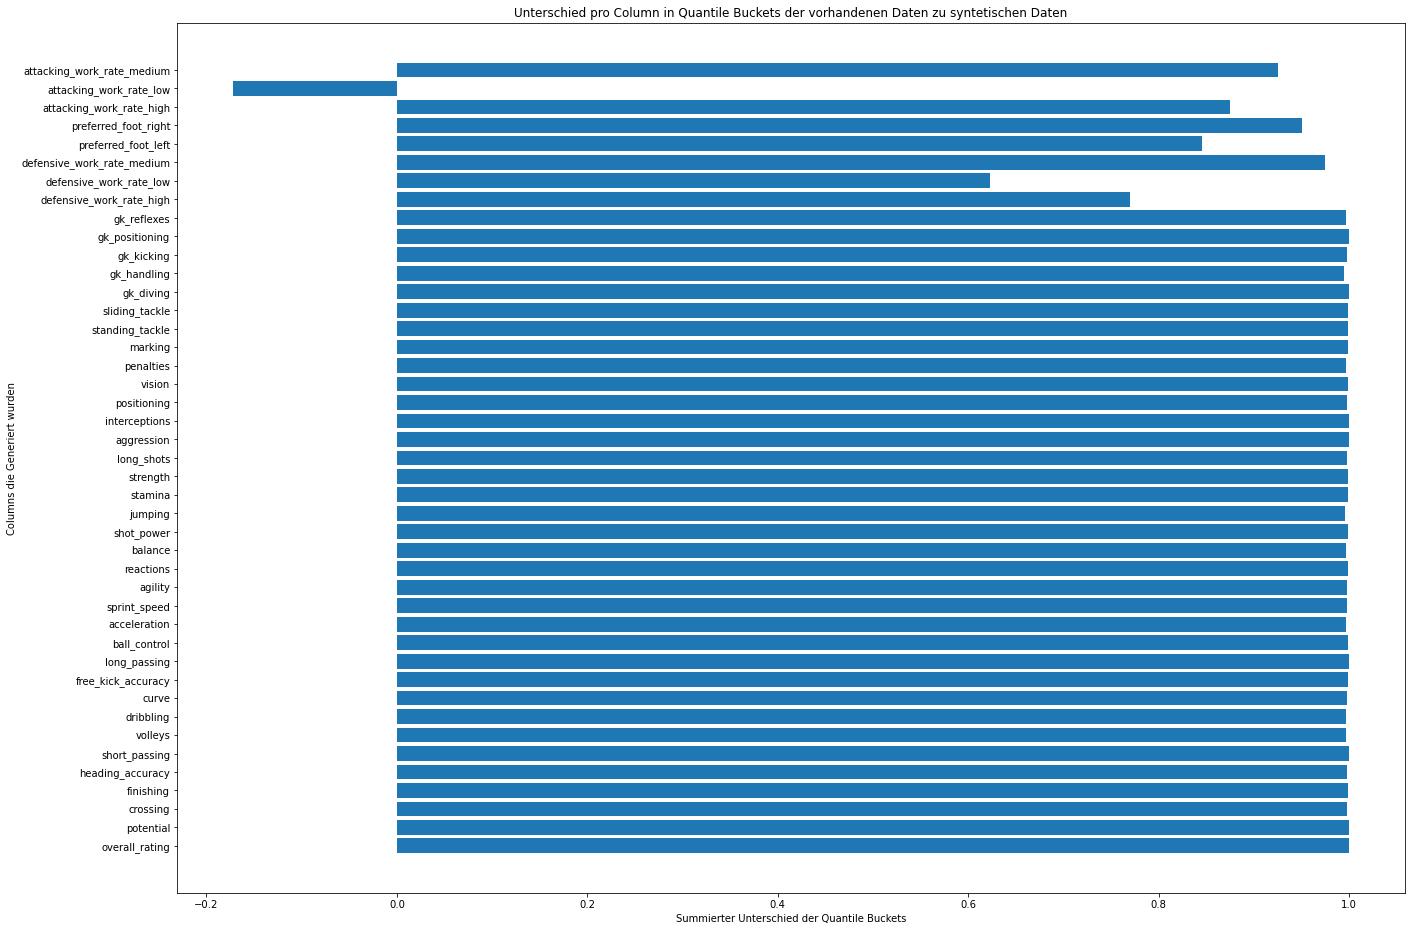

In [15]:
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [16]:
print(f'Overall accuracy: {sum(res) / len(res)}')

Overall accuracy: 0.9472034339882931


In [17]:
new_df[new_df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium


In [18]:
df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
df[df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
1992,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,77.0,...,14.0,11.0,0,1,0,0,1,1,0,0
6170,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,...,14.0,8.0,0,1,0,1,0,0,0,1


In [19]:
# Ich versuche jetzt, ein Generator Modell zu erstellen welches mir neue Daten anhand eines Noise Vektors generiert. 
# Der Generator selbst hat die Original Daten nie gesehen, er nimmt einfach nur Random entgegen und basierend darauf erstellt er etwas. 
# Wie gut das Ergebnis ist, bestimmt später der Discriminator, den ich vermutlich erst später implementiere.

# Zu beginn ist das Ziel, ein super einfachen Generator zu erstellen, der mir basierend auf die eingehende Anzahl an spalten "random" Ausgaben erzeugt. Logischerweise noch super random da 0 trainiert

In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Warum auch immer, bekomme ich einen fehler wenn ich das hier nicht drinne habe. 
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


from IPython import display

In [21]:
def make_generator_model(df):
    # Ich übernehme zu beginn, den Anfang des Generators aus dem Bild Generator
    model = tf.keras.Sequential()
    model.add(layers.Dense(df.shape[1] * 256, use_bias = False, input_shape=(100, ))) # Random Noise Vektor mal wieder 100 Dim als Input
    # model.add(layers.BatchNormalization()) # BN macht man meist nur bei CNNs..
    model.add(layers.LeakyReLU())
    
    #model.add(layers.Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # => None ist batch size, rest ist der Shape den wir haben wollen
    
    #model.add(layers.Flatten())
    model.add(layers.Dense(256, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(df.shape[1], use_bias = False))
    
    return model

In [22]:
train_df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
generator = make_generator_model(train_df)

noise = tf.random.normal([1, 100])

generated_data = generator(noise, training=False)
generated_data

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[ 0.06958305,  0.1577469 ,  0.12028182, -0.08392494, -0.05121903,
        -0.05598129, -0.05366829,  0.13720115,  0.14427474, -0.04977302,
        -0.00086136, -0.02521311, -0.13924684,  0.14682415,  0.2644163 ,
         0.00392523,  0.09234975,  0.08263956,  0.08031945, -0.00973075,
        -0.13048354,  0.03914452,  0.08911767, -0.07474972,  0.11968412,
         0.03963968, -0.00318008, -0.05184248, -0.04993706,  0.2372732 ,
        -0.08380207,  0.05474978, -0.10664611,  0.01896176, -0.04628021,
        -0.05264409,  0.11397736, -0.0501266 , -0.22517948, -0.0844484 ,
        -0.05313951, -0.02310856, -0.05293529]], dtype=float32)>

In [23]:
def make_discriminator_model(df):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [24]:
discriminator = make_discriminator_model(train_df)
decision = discriminator(generated_data)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00936498]], dtype=float32)>

In [25]:
# Cookie Cutter aus dem DCGAN Notebook
lerning_rate = 0.001
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(lerning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(lerning_rate)

#checkpoint_dir = './checkpoints/dcgan_soccer_2'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)


#seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def train(dataset, epochs, output=True):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        if output:
            display.clear_output(wait=True)
            #generate_and_save_images(generator, epoch + 1, seed)

        #if (epoch +1) % 199 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)
        
        if output:
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    if output:   
        display.clear_output(wait=True)
    #generate_and_save_images(generator, epoch + 1, seed)

In [34]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    print(predictions.shape)

In [35]:
from sklearn import preprocessing

x = train_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_train_df = pd.DataFrame(x_scaled)

In [36]:
BUFFER_SIZE = 9907
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_train_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [37]:
train(train_dataset, EPOCHS)

Time for epoch 50 is 0.125762939453125 sec


In [38]:
noise = tf.random.normal([9907, 100])

generated_data = generator(noise, training=False)
generated_data = min_max_scaler.inverse_transform(generated_data)

In [39]:
gan_df = pd.DataFrame(data=generated_data, columns=column_names).astype("float")

3753.8818092911415
Overall accuracy: 0.5431298994644158


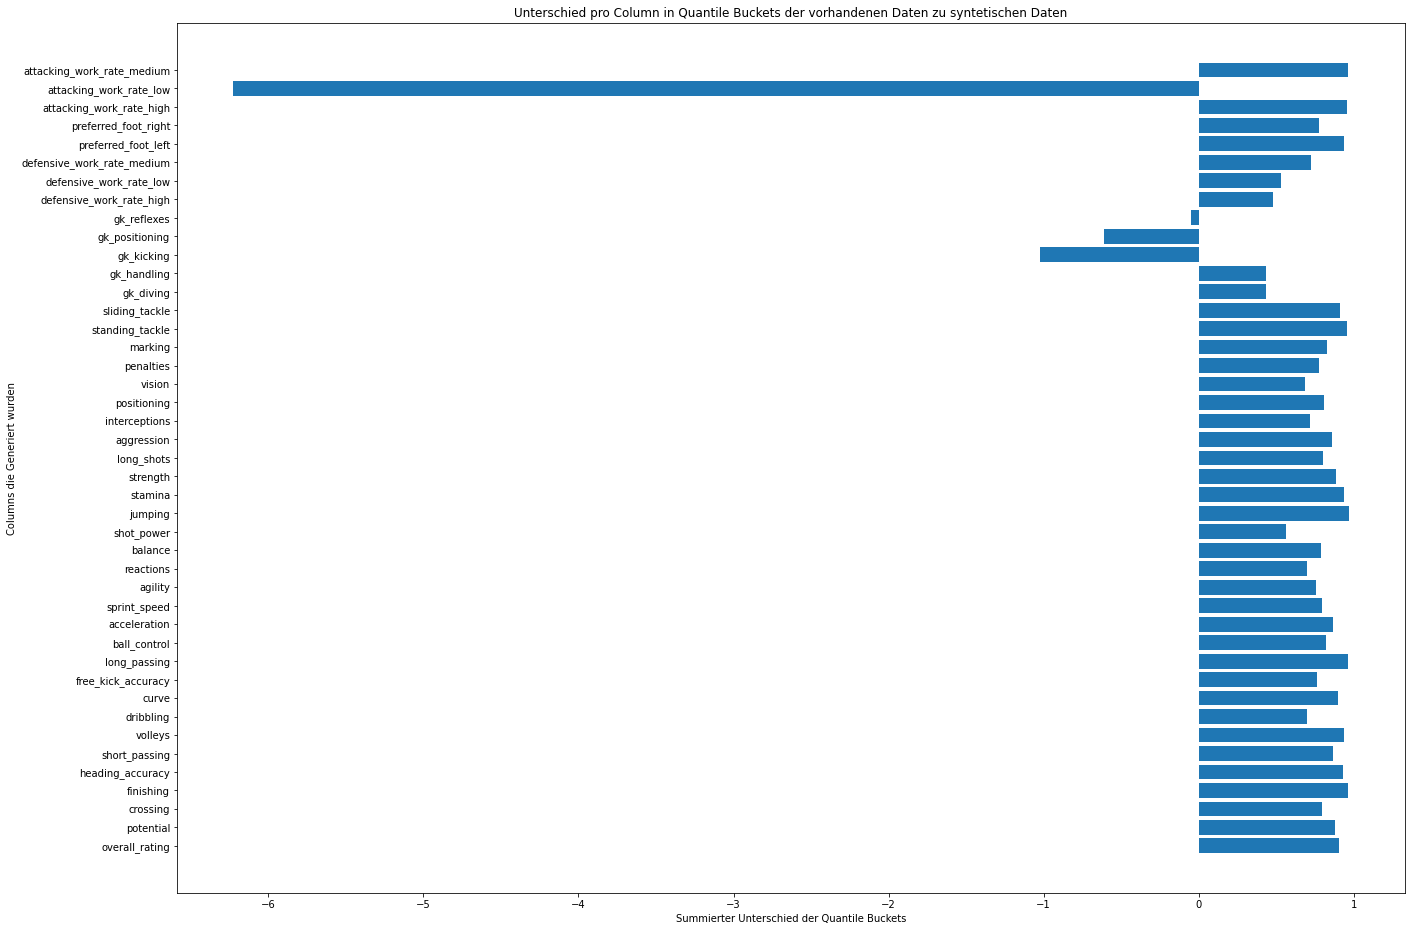

In [40]:
res, dif_total = compare_two_dataframe(gan_df, train_df, column_names, 100)
print(dif_total)
print(f'Overall accuracy: {sum(res) / len(res)}')
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [41]:
gan_df

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
0,64.756765,67.063224,45.751998,51.385458,44.152556,66.588639,45.759312,60.896412,34.649356,65.713606,...,1.395032,18.063020,0.194440,0.091311,0.928390,0.247841,0.831604,0.250725,-0.214732,0.695098
1,63.201228,70.794760,51.348405,53.699136,64.565043,78.237015,54.165687,90.432678,36.067750,78.261833,...,5.376551,15.210087,0.382446,0.077548,1.097396,0.382244,1.096357,0.419173,-0.345371,0.789073
2,60.706639,66.149370,35.682766,44.666899,44.067232,61.605749,36.773978,59.136106,42.684201,40.996471,...,0.102082,9.796640,0.206743,0.279845,0.891453,0.260563,0.699619,0.153670,-0.267144,0.609555
3,57.726099,63.474423,48.683300,26.596683,60.193938,60.362358,41.190510,84.222629,38.310557,55.829720,...,-11.501708,7.577991,0.409461,0.061528,1.004352,0.305584,0.857810,0.258747,-0.321186,0.705473
4,58.640638,66.774696,49.312512,39.225937,70.407687,70.478007,54.284261,100.999530,46.279904,67.952366,...,-10.109499,3.479419,0.446813,0.156394,1.061438,0.275598,1.047770,0.373132,-0.409990,0.728842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,66.103486,75.088782,49.789655,76.106015,69.206251,87.682270,60.689680,102.892140,55.996658,78.174650,...,6.802060,15.908495,0.465127,0.432079,1.234843,0.288154,1.274928,0.379337,-0.415712,0.939624
9903,58.253510,63.362937,47.764175,38.992134,60.223878,66.802377,50.644247,89.411631,46.501270,61.401505,...,-4.269836,3.646796,0.380098,0.074219,1.063151,0.318255,0.925260,0.282688,-0.343250,0.697145
9904,65.688790,68.964950,58.193408,72.687325,59.139305,84.029585,67.492213,88.971711,50.199905,85.272344,...,10.989831,10.537428,0.402309,0.177785,1.162377,0.343688,1.166541,0.476286,-0.339253,0.871378
9905,56.577260,57.165914,38.805402,40.953663,50.429232,63.891305,47.045511,72.802830,45.847410,43.755557,...,-7.664343,-17.424558,0.256741,0.169919,0.755123,0.281943,0.773905,0.120435,-0.224922,0.502542


In [42]:
gan_df[gan_df.overall_rating < 30]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium


In [43]:
train_df[train_df.overall_rating > 80]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
14,82.0,85.0,75.0,75.0,58.0,83.0,79.0,81.0,70.0,70.0,...,10.0,8.0,1,0,0,0,1,1,0,0
55,82.0,82.0,75.0,72.0,77.0,73.0,69.0,86.0,69.0,57.0,...,7.0,15.0,0,0,1,0,1,0,0,1
429,82.0,85.0,86.0,59.0,64.0,77.0,61.0,82.0,73.0,59.0,...,12.0,5.0,0,0,1,1,0,1,0,0
479,83.0,87.0,70.0,86.0,76.0,80.0,82.0,85.0,74.0,73.0,...,5.0,6.0,1,0,0,0,1,1,0,0
498,86.0,87.0,77.0,83.0,65.0,79.0,78.0,88.0,78.0,78.0,...,12.0,13.0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10867,82.0,84.0,72.0,72.0,46.0,79.0,74.0,92.0,84.0,78.0,...,7.0,7.0,0,0,1,0,1,0,0,1
10880,82.0,83.0,13.0,13.0,10.0,40.0,8.0,15.0,12.0,13.0,...,76.0,86.0,0,0,1,0,1,0,0,1
10911,85.0,85.0,67.0,82.0,74.0,86.0,68.0,81.0,80.0,85.0,...,12.0,8.0,0,1,0,0,1,0,0,1
10916,82.0,84.0,77.0,79.0,49.0,81.0,67.0,86.0,83.0,77.0,...,9.0,9.0,0,0,1,0,1,0,0,1


In [2]:
# undo, nur ein quick work arround da fehler oben:
df_one_hot_list = ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate']

# pd.get_dummies(s).idxmax(1)

def unsolve_one_hot(df, hot_cols):
    copy = df.copy()
    for col in hot_cols:
        loop_cols = df.filter(like=col).columns
        res = df[loop_cols].max(1)        
        copy[col] = pd.get_dummies(df[loop_cols]).idxmax(1).map(lambda x: x.lstrip(col).lstrip('_'))
        copy = copy.drop(loop_cols, axis=1)
    
    return copy
                

In [45]:
encoded = unsolve_one_hot(gan_df, df_one_hot_list)
encoded[encoded.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,defensive_work_rate,preferred_foot,attacking_work_rate


In [ ]:
# Ok, das Ziel ist es jetzt, die Spieler Tabelle zu generieren.

#1.) Laden der OG Daten:
con = sqlite3.connect("SoccerDataset/database.sqlite")
player_train_df = pd.read_sql_query('SELECT * from Player', con)
con.close()

In [ ]:
#2.) One-Hot Encoden von Spalten. Bei den Spielern nicht nötigt, da es keine Attrs. gibt
#3.) Vorbereiten anderer Datentypen, die Generiert werden sollen. Hier z.B. Geburtsdatum
player_train_df['birthday'] = pd.to_datetime(player_train_df['birthday'])
player_train_df['birthday'] = player_train_df.birthday.values.astype(np.int64) // 10 ** 9

In [ ]:
#4.) DF erstellen, über Daten die generiert werden sollen. Hier ist es relativ einfach 
training_cols = ['birthday', 'height', 'weight']
training_df = player_train_df[training_cols]

In [ ]:
#5.) Normalizieren der Daten, hier mal ein versuch mit SKLearn vll kann man es damit dann auch besser rückgängig machen:
from sklearn import preprocessing

x = training_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)

In [ ]:
#6.) Erstellen der benötigten Modelle, ich versuche es so zu machen, dass "ein" Modell für alle Situationen erstellt werden kann. Aber es muss immer neu trainiert werden...
generator = make_generator_model(norm_df)
discriminator = make_discriminator_model(norm_df)

BUFFER_SIZE = 11060
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(norm_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#7.) Magic
train(train_dataset, EPOCHS)

In [ ]:
#8.) Erstellen der Daten
noise = tf.random.normal([9907, 100]) #Wir hatten 9907 Spieler Attrs. deswegen auch mal so viele Spieler generieren!
generated_data = generator(noise, training=False)

In [ ]:
#9.) Dataframe erstellen, dass dauert bissel hart lange (im Verhältnis)
generated_data = min_max_scaler.inverse_transform(generated_data)
res_df = pd.DataFrame(data=generated_data, columns=training_cols).astype("float")

In [ ]:
#10.) OPTIONAL: Zurückwandeln der geänderten Zahlenwerte (hier birthday)
res_df['birthday'] = pd.to_datetime(res_df['birthday'], unit='s')

In [ ]:
res_df.loc[res_df.weight > 210]

In [ ]:
import namegenerator
import random 

def gen_name():
    name = namegenerator.gen()
    count = 10
    if random.randrange(0, 10) == 1:
        count = 1
    name = name.replace('-', ' ', count)
    name = " ".join(w.capitalize() for w in name.split())
    
    part = name.split(' ')
    return part[0] + ' ' + part[1]
    
gen_name()

In [ ]:
names = []
for i in range(9907):
    names.append(gen_name())

In [ ]:
res_df['Names'] = names

In [ ]:
res_df

In [32]:
def distance(d1, d2, limit):
    diff = []
    diff_ab = []
    for l1, l2 in zip(d1, d2):
        if not isinstance(l1, str) and not isinstance(l2, str):
            diff.append(l1 - l2)
            
            if not l2 == 0:
                diff_ab.append(l1 / l2 < (1 + limit) and l1 / l2 > (1 - limit))
            else:
                diff_ab.append(True)
        else:
            diff.append("-")
            diff_ab.append("-")  
            
    return (diff, diff_ab)

def count_trues(diff_list_ab):
    total = 0
    total_hits = 0
    for l in diff_list_ab:
        if l:
            total_hits += 1
        if l != '-':
            total += 1 
    return (total, total_hits)

def compare_min_max(original, generated, limit = 0.15):
    omins = [m for m in original.min()]
    omaxs = [m for m in original.max()]
    gmins = [m for m in generated.min()]
    gmaxs = [m for m in generated.max()]
    
    diff_min, diff_min_ab = distance(omins, gmins, limit)
    diff_max, diff_max_ab = distance(omaxs, gmaxs, limit)
    data = [omins, gmins, diff_min, diff_min_ab, omaxs, gmaxs, diff_max, diff_max_ab]
    
    min_total, min_total_hits = count_trues(diff_min_ab)
    max_total, max_total_hits = count_trues(diff_max_ab)
    total = min_total + max_total
    hits = min_total_hits + max_total_hits
    percent = hits / total
    
    print("Total number labels: {0}\nNumber of correct labels:{1}\nAccuracy:{2:2.2f}".format(total, hits, percent))    
    return pd.DataFrame(data=data, columns=original.columns, index=['OGMins', 'GenMin', 'DiffMin', 'DiffMinLimit', 'OGMax', 'GenMax', 'DiffMax', 'DiffMaxLimit']).T

In [ ]:
stats_df = unsolve_one_hot(train_df, ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate'])

In [ ]:
res = compare_min_max(stats_df, encoded)

In [ ]:
res

In [ ]:
# Hier wäre jetzt sowas cool wie ein durchprobieren von verschiedenen Dingen. 
con = sqlite3.connect("SoccerDataset/database.sqlite")

# Load the data into a DataFrame
inner = 'SELECT player_api_id, MAX(date) as date FROM player_attributes GROUP BY player_api_id'
og_train_df = pd.read_sql_query('SELECT * from Player p INNER JOIN ('+ inner +') Sub1 ON p.player_api_id = Sub1.player_api_id INNER JOIN player_attributes ON player_attributes.player_api_id = Sub1.player_api_id AND player_attributes.date = Sub1.date', con)

con.close()

In [ ]:
train_df = prepare_dataframe(og_train_df)

In [ ]:
train_df = train_df.loc[:, 'overall_rating':'attacking_work_rate_medium']

In [ ]:
def make_cus_generator_model(df, modelType):
    # Ich übernehme zu beginn, den Anfang des Generators aus dem Bild Generator
    model = tf.keras.Sequential()
    model.add(layers.Dense(df.shape[1] * 256, use_bias = False, input_shape=(100, ))) # Random Noise Vektor mal wieder 100 Dim als Input
    model.add(layers.LeakyReLU())    

    if modelType > 4:
        model.add(layers.Dense(1024, use_bias = False))
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(1024, use_bias = False))
        model.add(layers.LeakyReLU()) 
    
    if modelType > 3:
        model.add(layers.Dense(1024, use_bias = False))
        model.add(layers.LeakyReLU())   
    
    if modelType > 2:
        model.add(layers.Dense(512, use_bias = False))
        model.add(layers.LeakyReLU())   
    
    if modelType > 1:
        model.add(layers.Dense(256, use_bias = False))
        model.add(layers.LeakyReLU())
    
    if modelType > 0:
        model.add(layers.Dense(128, use_bias = False))
        model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(df.shape[1], use_bias = False))
    
    return model

In [ ]:
def make_cus_discriminator_model(df, modelType):
    model = tf.keras.Sequential()

    if modelType == 5:
        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())
        
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU()) 
    
    if modelType == 4:
        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU()) 
    
    if modelType == 3:
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU()) 
    
    if modelType == 2:
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
    
    if modelType == 1:
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(64))
        model.add(layers.LeakyReLU())        
    
    if modelType == 0:
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(64))
        model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
from sklearn import preprocessing

x = train_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)

In [ ]:
BUFFER_SIZE = 9907
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(norm_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
training_cols = list(train_df.columns)

res = []

for gens in range(5): # Number of possible Gen Models 5
    for disc in range(6): # Number of possible Disc Models 6
        generator = make_cus_generator_model(norm_df, gens)
        discriminator = make_cus_discriminator_model(norm_df, disc)
        
        @tf.function
        def train_step(images):
            noise = tf.random.normal([BATCH_SIZE, noise_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)
                real_output = discriminator(images, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        train(train_dataset, EPOCHS * 10, False)
        display.clear_output(wait=True)
        
        noise = tf.random.normal([9907, 100])
        generated_data = generator(noise, training=False)
        
        generated_data = min_max_scaler.inverse_transform(generated_data)
        res_df = pd.DataFrame(data=generated_data, columns=training_cols).astype("float")
        res_df = unsolve_one_hot(res_df, ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate'])
        print("Generator Model: {0} with Discriminator Model: {1}".format(gens, disc))
        compare = compare_min_max(train_df, res_df)
        res.append(((gens, disc), compare))

In [76]:
old

[((0, 0), (70, 11, 0.15714285714285714)),
 ((0, 1), (70, 14, 0.2)),
 ((0, 2), (70, 7, 0.1)),
 ((0, 3), (70, 20, 0.2857142857142857)),
 ((0, 4), (70, 15, 0.21428571428571427)),
 ((0, 5), (70, 12, 0.17142857142857143)),
 ((1, 0), (70, 18, 0.2571428571428571)),
 ((1, 1), (70, 20, 0.2857142857142857)),
 ((1, 2), (70, 22, 0.3142857142857143)),
 ((1, 3), (70, 18, 0.2571428571428571)),
 ((1, 4), (70, 11, 0.15714285714285714)),
 ((1, 5), (70, 20, 0.2857142857142857)),
 ((2, 0), (70, 24, 0.34285714285714286)),
 ((2, 1), (70, 21, 0.3)),
 ((2, 2), (70, 18, 0.2571428571428571)),
 ((2, 3), (70, 27, 0.38571428571428573)),
 ((2, 4), (70, 18, 0.2571428571428571)),
 ((2, 5), (70, 16, 0.22857142857142856)),
 ((3, 0), (70, 18, 0.2571428571428571)),
 ((3, 1), (70, 15, 0.21428571428571427)),
 ((3, 2), (70, 19, 0.2714285714285714)),
 ((3, 3), (70, 21, 0.3)),
 ((3, 4), (70, 21, 0.3)),
 ((3, 5), (70, 19, 0.2714285714285714)),
 ((4, 0), (70, 17, 0.24285714285714285)),
 ((4, 1), (70, 15, 0.21428571428571427)),


In [78]:
old2

[((0, 0), (70, 13, 0.18571428571428572)),
 ((0, 1), (70, 13, 0.18571428571428572)),
 ((0, 2), (70, 18, 0.2571428571428571)),
 ((0, 3), (70, 12, 0.17142857142857143)),
 ((0, 4), (70, 19, 0.2714285714285714)),
 ((0, 5), (70, 9, 0.12857142857142856)),
 ((1, 0), (70, 20, 0.2857142857142857)),
 ((1, 1), (70, 27, 0.38571428571428573)),
 ((1, 2), (70, 17, 0.24285714285714285)),
 ((1, 3), (70, 25, 0.35714285714285715)),
 ((1, 4), (70, 19, 0.2714285714285714)),
 ((1, 5), (70, 13, 0.18571428571428572)),
 ((2, 0), (70, 14, 0.2)),
 ((2, 1), (70, 20, 0.2857142857142857)),
 ((2, 2), (70, 15, 0.21428571428571427)),
 ((2, 3), (70, 23, 0.32857142857142857)),
 ((2, 4), (70, 15, 0.21428571428571427)),
 ((2, 5), (70, 10, 0.14285714285714285)),
 ((3, 0), (70, 18, 0.2571428571428571)),
 ((3, 1), (70, 13, 0.18571428571428572)),
 ((3, 2), (70, 13, 0.18571428571428572)),
 ((3, 3), (70, 24, 0.34285714285714286)),
 ((3, 4), (70, 11, 0.15714285714285714)),
 ((3, 5), (70, 10, 0.14285714285714285)),
 ((4, 0), (70, 

In [85]:
res

[]

In [11]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Warum auch immer, bekomme ich einen fehler wenn ich das hier nicht drinne habe.
#session.close()
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

def unsolve_one_hot(df, hot_cols):
    copy = df.copy()
    for col in hot_cols:
        loop_cols = df.filter(like=col).columns
        res = df[loop_cols].max(1)        
        copy[col] = pd.get_dummies(df[loop_cols]).idxmax(1).map(lambda x: x.lstrip(col).lstrip('_'))
        copy = copy.drop(loop_cols, axis=1)
    
    return copy

In [33]:
from sklearn import preprocessing
import pandas as pd
import sqlite3
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers


def sql_identifier(s):
    return '"' + s.replace('"', '""') + '"'
        
def get_table_order(db):
    '''This method returns the order of tables to be generated. Tables have relations between each other (FK) that needs to be created first in order to generate consistend data. 
    TODO: Remove pk; fk stuff from here. Method already big enough, will get own method to call when needed. '''
    rows = db.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
    tables = [row[0].lower() for row in rows]
    tables.remove('sqlite_sequence')
    
    fk_relation = {}
    pk_relation = {}
    
    table_order = []
    
    for table in tables:
        rows = db.execute("PRAGMA table_info({})".format(sql_identifier(table)))
        attributes = rows.fetchall()
        
        pk = []
        for attr in attributes:
            if attr[5] == 1:
                pk.append(attr[1])    
        pk_relation[table] = pk
        
        rows = db.execute("PRAGMA foreign_key_list({})".format(sql_identifier(table)))
        foreign_key_list = rows.fetchall()
        fkeys = []
        for fk in foreign_key_list:
            fkeys.append((fk[2].lower(), fk[3], fk[4]))
        fk_relation[table] = fkeys
        
        if not fkeys:
            table_order.append(table)
        else:
            contained = True
            depends = []
            for fk in fkeys:
                if fk[0] not in depends:
                    depends.append(fk[0])
                if fk[0] not in table_order:
                    contained = False
            if contained:
                #table_order.append((table, depends))
                table_order.append(table)
                
                
    maxLoop = 5
    while len(table_order) <= len(tables):
        for table, fkeys in fk_relation.items():
            if table in table_order:
                continue
                
            contained = True
            depends = []
            for fk in fkeys:
                if fk[0] not in depends:
                    depends.append(fk[0])
                if fk[0] not in table_order:
                    contained = False
            if contained:
                table_order.append(table)  
                
        maxLoop -= 1
        if maxLoop <= 0:
            break
        
    return table_order

In [34]:
'''The next step needs to be going through the list of tables the check each attribute for the type. We dont want to generate strings. This way, we can create the list of attributes 
that should be generated for each table. After the creation append random generated attributes that are missing (and most likley with no mean at all e.g. STRINGS).

First we can just try and generate everything without a releation to each other. This may result in countries like Monaco may have far more professionell soccer player than ppl living in Monaco. '''

'The next step needs to be going through the list of tables the check each attribute for the type. We dont want to generate strings. This way, we can create the list of attributes \nthat should be generated for each table. After the creation append random generated attributes that are missing (and most likley with no mean at all e.g. STRINGS).\n\nFirst we can just try and generate everything without a releation to each other. This may result in countries like Monaco may have far more professionell soccer player than ppl living in Monaco. '

In [35]:
def auto_one_hot_encode(df, column):
    total_len = len(df)
    values = df[column].unique()
    drop = []
    for value in values:
        if len(df[df[column].isin([value])]) < total_len * 0.02: # Hier setze ich die Grenze auf 2%. D.h. eine Ausprägung muss mid. 2% der Daten betreffen damit es eine eigene One-Hot bekommt
            drop.append(value)
            
    df = df[~df[column].isin(drop)] # lösche alle Werte die zu gering sind
    
    return pd.get_dummies(df[column], prefix=column)

def generatable_column(attributes, df):
    '''0 = Primary Key | '''
    
    if 'id' in attributes[1].lower():
        return 0
    
    if attributes[2].lower() == 'integer':
        return 1
    
    if attributes[2].lower() == 'numeric':
        return 1
    
    if attributes[2].lower() == 'text':
        values = df[attributes[1]].unique()
        
        if len(values) < 5: #Diesen Wert ggf. noch als parameter machen
            return 2 # Bei diesen Werten ist es sinnvoll ein auto one-hot zu machen. Deswegen wird das einfach mal mit überreicht.
        #TODO: Auto One-Hot encoding für die hier hin

def table_foreign_keys(db, table):
    rows = db.execute("PRAGMA foreign_key_list({})".format(sql_identifier(table)))
    foreign_key_list = rows.fetchall()
    fkeys = []
    for fk in foreign_key_list:
        fkeys.append(fk[3])
    
    return fkeys

def generatable_rows(db, table, table_df):
    rows = db.execute("PRAGMA table_info({})".format(sql_identifier(table)))
    attributes = rows.fetchall()
    res = []
    one_hot = []
    fkeys = table_foreign_keys(db, table)
    
    for att in attributes:
        if att[1] in fkeys:
            continue
        
        col = generatable_column(att, table_df)
        if col == 1:
            res.append(att[1])
        elif col == 2:
            res.append(att[1])
            one_hot.append(att[1])
    
    return (res, one_hot)

def preprocess_dataset(df, one_hot):
    for hots in one_hot:
        encoded_df = auto_one_hot_encode(df, hots)
        df = pd.concat([df, encoded_df],axis=1)
        df = df.drop(hots, axis=1)  
    return df

def prepare_datasets(db, table_ordered):
    prepared_dataframes = []
    all_rows = []
    all_one_hot = []
    all_table = []
    
    
    for table in table_ordered:
        table_df = pd.read_sql_query('SELECT * from ' + table, db)
        table_columns = list(table_df.columns) 
        rows, one_hot = generatable_rows(db, table, table_df)
        
        if not rows:
            print(f'No columns can be generated for "{table}"')
            continue

        # Als nächstest kommt das preprocessing. Hier werden Daten z.B. one-hot encoded
        table_df = preprocess_dataset(table_df, one_hot)

        generate_df = table_df.drop(list(set(rows) ^ set(table_columns)), axis=1)
        len_with_nan = len(generate_df)
        generate_df = generate_df.dropna()

        all_rows.append(list(generate_df.columns))
        all_one_hot.append(one_hot)
        all_table.append(table)
        
        prepared_dataframes.append(generate_df)
        
        print('Reduced the sice of the dataset "{}" with removing all NaN rows. Before: {} After: {}'.format(table, len_with_nan, len(generate_df)))
        
        
    return (prepared_dataframes, all_rows, all_one_hot, all_table)

In [41]:
tf.keras.backend.set_floatx('float64')

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def make_generator_model(df):
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, use_bias = False, input_shape=(100, )))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(256, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(df.shape[1], use_bias = False))
    
    return model

def make_discriminator_model(df):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def train(dataset, BATCH_SIZE, epochs, noise_dim, generator, discriminator, lerning_rate):
    '''Normal würde hier dann noch sowas wie Zeitmessung kommen usw. habe ich erstmal hier gescrapped um es übersichtlich zu halten'''
    generator_optimizer = tf.keras.optimizers.Adam(lerning_rate)
    discriminator_optimizer = tf.keras.optimizers.Adam(lerning_rate)
    
    @tf.function #Weiß der Geier warum ich es jedesmal neu definieren muss. Meine vermutung ist, dass intern sonst die falschen Modelle verwendet werden.
    def train_step(images, BATCH_SIZE, epochs, noise_dim, generator, discriminator, lerning_rate, discriminator_optimizer, generator_optimizer):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])


        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    for epoch in range(epochs):        
        for image_batch in dataset:
            train_step(image_batch, BATCH_SIZE, epochs, noise_dim, generator, discriminator, lerning_rate, discriminator_optimizer, generator_optimizer)

def training_process(df):
    print('Beginning training')
    
    BATCH_SIZE = 256
    EPOCHS = 20
    noise_dim = 100
    lerning_rate = 0.001
    
    # 1.) Normalisieren
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    norm_df = pd.DataFrame(x_scaled)
    
   
    generator = make_generator_model(norm_df)
    discriminator = make_discriminator_model(norm_df)
    train_dataset = tf.data.Dataset.from_tensor_slices(norm_df).shuffle(len(df)).batch(BATCH_SIZE)
    
    train(train_dataset, BATCH_SIZE, EPOCHS, noise_dim, generator, discriminator, lerning_rate)
    
    return (generator, min_max_scaler)

def check_accuray(generator, df, scaler, one_hot, columns):
    noise = tf.random.normal([len(df), 100])
    generated_data = generator(noise, training=False)
    
    generated_data = scaler.inverse_transform(generated_data)
    res_df = pd.DataFrame(data=generated_data, columns=columns).astype("float")
    stats_df = unsolve_one_hot(res_df, one_hot)
    return compare_min_max(df, stats_df)

In [42]:
accuracy = []

def generate_data_from_sql(path):    
    db = sqlite3.connect(path)
    table_ordered = get_table_order(db)
    trainable_df, all_rows, all_one_hot, tables = prepare_datasets(db, table_ordered) # ggf. umbauen, sodas nicht direkt die liste reingeht sondern bereits hier geloopt wird über die tables   
    
    for df, columns, one_hot, table in zip(trainable_df, all_rows, all_one_hot, tables):
        print(f'Beginn process with {table} with the shape {df.shape} and in total {len(columns)} with One-Hot Cols: {len(one_hot)}')
        generator, scaler = training_process(df)
        og_df = unsolve_one_hot(df, one_hot)
        acc = check_accuray(generator, og_df, scaler, one_hot, columns)
        accuracy.append(acc)
        
    db.close()

In [43]:
generate_data_from_sql("SoccerDataset/database.sqlite")

Reduced the sice of the dataset "player" with removing all NaN rows. Before: 11060 After: 11060
No columns can be generated for "country"
No columns can be generated for "team"
Reduced the sice of the dataset "team_attributes" with removing all NaN rows. Before: 1458 After: 468
Reduced the sice of the dataset "player_attributes" with removing all NaN rows. Before: 183978 After: 181265
No columns can be generated for "league"
Reduced the sice of the dataset "match" with removing all NaN rows. Before: 25979 After: 2755
Beginn process with player with the shape (11060, 2) and in total 2 with One-Hot Cols: 0
Beginning training
Total number labels: 4
Number of correct labels:2
Accuracy:0.50
Beginn process with team_attributes with the shape (468, 37) and in total 37 with One-Hot Cols: 11
Beginning training
Total number labels: 16
Number of correct labels:22
Accuracy:1.38
Beginn process with player_attributes with the shape (181265, 36) and in total 36 with One-Hot Cols: 1
Beginning training

In [46]:
accuracy[0]

,OGMins,GenMin,DiffMin,DiffMinLimit,OGMax,GenMax,DiffMax,DiffMaxLimit
height,157.48,173.798,-16.3178,True,208.28,191.209,17.0709,True
weight,117,154.341,-37.3407,False,243,194.549,48.4511,False


In [47]:
accuracy[1]

,OGMins,GenMin,DiffMin,DiffMinLimit,OGMax,GenMax,DiffMax,DiffMaxLimit
buildUpPlaySpeed,26,-414.089,440.089,False,80,-152.038,232.038,False
buildUpPlayDribbling,24,-68.2026,92.2026,False,66,-4.3411,70.3411,False
buildUpPlayPassing,20,157.491,-137.491,False,79,368.115,-289.115,False
chanceCreationPassing,21,2.4986,18.5014,False,77,123.063,-46.0631,False
chanceCreationCrossing,23,53.1842,-30.1842,False,80,170.718,-90.7176,False
chanceCreationShooting,22,67.1331,-45.1331,False,80,173.868,-93.8684,False
defencePressure,23,-285.898,308.898,False,72,-91.4258,163.426,False
defenceAggression,24,-372.722,396.722,False,72,-135.699,207.699,False
buildUpPlaySpeedClass,Balanced,Slow,-,-,Slow,Slow,-,-
buildUpPlayDribblingClass,Little,Little,-,-,Normal,Little,-,-


In [48]:
accuracy[2]

,OGMins,GenMin,DiffMin,DiffMinLimit,OGMax,GenMax,DiffMax,DiffMaxLimit
overall_rating,33,67.5813,-34.5813,False,94,132.51,-38.51,False
potential,39,58.8499,-19.8499,False,97,94.6062,2.39384,True
crossing,1,55.0567,-54.0567,False,95,176.308,-81.3079,False
finishing,1,44.7566,-43.7566,False,97,116.451,-19.4508,False
heading_accuracy,1,62.77,-61.77,False,98,177.051,-79.0513,False
short_passing,3,45.5745,-42.5745,False,97,105.637,-8.63687,True
volleys,1,43.6011,-42.6011,False,93,128.694,-35.6944,False
dribbling,1,51.1944,-50.1944,False,97,158.845,-61.8451,False
curve,2,50.5877,-48.5877,False,94,161.204,-67.2036,False
free_kick_accuracy,1,40.1088,-39.1088,False,97,142.21,-45.2098,False


In [50]:
accuracy[3]

,OGMins,GenMin,DiffMin,DiffMinLimit,OGMax,GenMax,DiffMax,DiffMaxLimit
stage,1,1.65239,-0.652392,False,38,16.8888,21.1112,False
home_team_goal,0,-0.594449,0.594449,False,9,3.60596,5.39404,False
away_team_goal,0,0.069345,-0.069345,False,7,6.16694,0.833058,True
home_player_X1,1,0.690607,0.309393,False,1,1.20146,-0.201465,False
home_player_X2,1,1.3947,-0.394704,False,6,4.82837,1.17163,False
...,...,...,...,...,...,...,...,...
GBD,2.2,0.737623,1.46238,False,11,5.51348,5.48652,False
GBA,1.13,-5.118,6.248,False,29,5.34323,23.6568,False
BSH,1.06,0.917986,0.142014,False,15,17.3283,-2.32834,True
BSD,2.2,-1.8365,4.0365,False,12,4.00193,7.99807,False


In [94]:
import numpy as np

def cal_max(teacher_preds, num_labels):
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=num_labels)
        max_label = np.argmax(label_counts)
        indices.append(max_label)
    return np.array(indices)

def noisy_max(teacher_preds, privacy_loss_lv, n_labels): 
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=n_labels)
        noisy_counts = label_counts + np.random.laplace(np.zeros(len(label_counts)), np.ones(len(label_counts))/privacy_loss_lv, len(label_counts))
        indices.append(np.argmax(noisy_counts))
    return np.array(indices)

In [95]:
for col in column_names:
    df[col] = df[col].astype(int)

In [104]:
from syft.frameworks.torch.dp import pate

# reduce the size, since with all 10k data it will take ages..
p_df = df[:100]
g_df = new_df[:100]

og_df = p_df.to_numpy()
tp_df = g_df.to_numpy()

indices = cal_max(og_df.T, p_df.shape[0])
print(indices)

[ 0  0  0  0  0 77  0  0 15  0  0  0  0  0  0 52  0  0  0  0  0  0  0  0
 56  0  0  0  0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [105]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=tp_df.T, indices=indices, noise_eps=0.001, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 1.4409156831212786
Data Dependent Epsilon: 1.4409156831212786
